# Time series analysis of currency and trade data

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from scipy.stats import pearsonr, spearmanr, kendalltau

In [84]:
def rolling_statistic(df, window_size = 6, statistic = 'mean'):
    '''
    Computes a rolling statistic of a Pandas dataframe with a single column.
    parameters:
    ----------------
    df : dataframe with a single column on which the function is to be applied.
    window_size: Size of the moving window. This is the number of observations used for
    calculating the statistic. Each window will be a fixed size.
    statistic: The statistic to be computed for each window. 'mean' (default), 'std' or 'IQR' (interquartile range). 
    Returns:
    ---------------
    Data frame with the rolling statistic.
    '''
    if statistic == 'mean':
        return df.rolling(window_size).mean()
    elif statistic == 'std':
        return df.rolling(window_size).std()
    elif statistic == 'IQR':
        Q1 = df.rolling(window_size).quantile(0.25)
        Q3 = df.rolling(window_size).quantile(0.75)
        
        return Q3-Q1
    else:
        print('Choose a valid statistic option: mean, std or IQR')
        return None

def diff_calculator(df, period):
    '''
    Calculates the difference of a DataFrame element compared with another element in the DataFrame.
    Parameters:
    ------------
    df: dataframe
    period: Periods to shift for calculating difference.
   
    '''
    return df.diff(periods=period)

def pct_change_calculator(df, period):
    '''
    Calculates the percentage change of a DataFrame element compared with another element in the DataFrame.
    Parameters:
    ------------
    df: dataframe 
    period: Periods to shift for calculating difference.
   
    '''
    return df.pct_change(periods=period)

def crosscorr_old(datax, datay, lag=0, wrap=False, method = 'pearson'):
    """ Lag-N cross correlation. Uses corr() method of  Pandas.
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy, method = method)
    else: 
        return datax.corr(datay.shift(lag), method = method)

    
def crosscorr(datax, datay, lag=0, method = 'pearson'):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : tuple, first element is cross-correlation coeff and the 2nd element is p-value (2-tailed)
    """

    # Remove the NaN values generated as part of the rolling average/diff/percent change calculations.
    data_xy = pd.concat([datax, datay], axis=1).dropna()
    data_x = data_xy.iloc[:,0]
    data_y = data_xy.iloc[:,1]
    
    if method == 'pearson':
        return pearsonr(data_x[lag:],data_y.shift(lag)[lag:])
    elif method == 'spearman':
        return spearmanr(data_x[lag:],data_y.shift(lag)[lag:])
    elif method == 'kendall':
        return kendalltau(data_x[lag:],data_y.shift(lag)[lag:])



In [85]:
def compute_rs_and_change_mass(df, window_size_mass =1, window_size_value =1, window_size_exchange = 1,statistic='mean', period = 1, currency = 'euro', change_type = 'diff'):
    '''
    Computes rolling statistic and the change in values (percent change or n-th order diff)
    Parameters:
    --------------
    df: dataframe
    window_size_mass: window size to use for rolling statistic -- import/export mass values
    window_size_value: window size to use for rolling statistic -- import/export trade values
    window_size_exchange: window size to use for rolling statistic -- exchange rate values
    statistic: to be used for each rolling window, 'mean' (default), 'std' or 'IQR'
    period: Order of diff/pct_change calculator
    currency: currency specification for slicing the appropriate column for exchange rates
    change_type: either 'diff' (default) or 'pct_change'
    Returns:
    ------------
    Dataframe 
    '''
    df_mass = df[['period','net_mass_kg_imp', 'net_mass_kg_exp']].set_index('period')
    df_exchange =  df[['period', 'month_{}_gbp'.format(currency)]].set_index('period')
    mass_rs_df = rolling_statistic(df_mass, window_size= window_size_mass,statistic= statistic)
    exchange_rs_df = rolling_statistic(df_exchange, window_size= window_size_exchange,statistic= statistic)
    rs_df = pd.concat([mass_rs_df, exchange_rs_df], axis = 1)
    if change_type == 'diff':
        rs_ch_df = diff_calculator(rs_df, period = period)
    elif change_type == 'pct_change':
        rs_ch_df = pct_change_calculator(rs_df, period = period)
    return rs_ch_df

def plot_cross_correlation_mass(hs4_df, hs4_code, trade_dir = 'exp', method = 'pearson'):
    '''
    This function plots the cross correlation of a particular hs4 code over time.
    We are shifiting the currency with respect to the trade time series. Therefore only a positive lag is realistic in
    this context.
    
    Parameters:
    --------------
    hs4_df: currency and trade information dataframe
    trade_dir: whether import ('imp') or export ('exp')
    method: 'pearson', 'spearman', or 'kendall'
    Returns:
    ------------
    Dataframe 
    '''
    lag_range = np.arange(0,21)
    # merged the df's on the period after dropping the NaNs
    merged_hs4_df = pd.merge(hs4_df[['net_mass_kg_{}'.format(trade_dir)]].dropna(), hs4_df[['month_{}_gbp'.format(currency)]].dropna(), on = 'period')
    corrcoef_list = [crosscorr(merged_hs4_df['net_mass_kg_{}'.format(trade_dir)],merged_hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[0] for lag in lag_range]
    pval_list = [crosscorr(merged_hs4_df['net_mass_kg_{}'.format(trade_dir)],merged_hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[1] for lag in lag_range]
    plt.figure(figsize = (12,6))
    plt.plot(lag_range, corrcoef_list, 'bo-', label = 'correlation coefficient');
    plt.plot(lag_range, pval_list, 'ro-', label = 'p-value');
    plt.axhline(0.05, ls='--');
    plt.axhline(0.1, ls='--');
    plt.xlabel('Lag (months)');
    plt.ylabel('{} correlation coefficient'.format(method));
    plt.title('HS4 code: {}'.format(hs4_code));
    plt.legend()

    
    
def compute_rs_and_change_trade(df, window_size_value =12, window_size_exchange = 1,statistic='mean', period = 1, currency = 'euro', change_type = 'diff'):
    '''
    Computes rolling statistic and the change in values (percent change or n-th order diff)
    Parameters:
    --------------
    df: dataframe
    window_size_value: window size to use for rolling statistic -- import/export trade values (amount)
    window_size_exchange: window size to use for rolling statistic -- exchange rate values
    statistic: to be used for each rolling window, 'mean' (default), 'std' or 'IQR'
    period: Order of diff/pct_change calculator
    currency: currency specification for slicing the appropriate column for exchange rates
    change_type: either 'diff' (default) or 'pct_change'
    Returns:
    ------------
    Dataframe 
    '''
    df_trade = df[['period','values_pounds_imp', 'values_pounds_exp']].set_index('period')
    df_exchange =  df[['period', 'month_{}_gbp'.format(currency)]].set_index('period')
    mass_rs_df = rolling_statistic(df_trade, window_size= window_size_value,statistic= statistic)
    exchange_rs_df = rolling_statistic(df_exchange, window_size= window_size_exchange,statistic= statistic)
    rs_df = pd.concat([mass_rs_df, exchange_rs_df], axis = 1)
    if change_type == 'diff':
        rs_ch_df = diff_calculator(rs_df, period = period)
    elif change_type == 'pct_change':
        rs_ch_df = pct_change_calculator(rs_df, period = period)
    return rs_ch_df

def plot_cross_correlation_trade(hs4_df, hs4_code, trade_dir = 'exp', method = 'pearson'):
    '''
    This function plots the cross correlation of a particular hs4 code over time.
    We are shifiting the currency with respect to the trade time series. Therefore only a positive lag is realistic in
    this context.
    
    Parameters:
    --------------
    hs4_df: currency and trade information dataframe
    trade_dir: whether import ('imp') or export ('exp')
    method: 'pearson', 'spearman', or 'kendall'
    Returns:
    ------------
    Dataframe 
    '''
    lag_range = np.arange(0,21)
    # merged the df's on the period after dropping the NaNs
    merged_hs4_df = pd.merge(hs4_df[['values_pounds_{}'.format(trade_dir)]].dropna(), hs4_df[['month_{}_gbp'.format(currency)]].dropna(), on = 'period')
    corrcoef_list = [crosscorr(merged_hs4_df['values_pounds_{}'.format(trade_dir)],merged_hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[0] for lag in lag_range]
    pval_list = [crosscorr(merged_hs4_df['values_pounds_{}'.format(trade_dir)],merged_hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[1] for lag in lag_range]
    plt.figure(figsize = (12,6))
    plt.plot(lag_range, corrcoef_list, 'bo-', label = 'correlation coefficient');
    plt.plot(lag_range, pval_list, 'ro-', label = 'p-value');
    plt.axhline(0.05, ls='--');
    plt.axhline(0.1, ls='--');
    plt.xlabel('Lag (months)');
    plt.ylabel('{} correlation coefficient'.format(method));
    plt.title('HS4 code: {}'.format(hs4_code));
    plt.legend()

In [86]:
def compute_crosscorr_and_pval_hs4(hs4_trade_cc, currency, trade_dir, method = 'pearson', statistic = 'mean',
                       change_type = 'pct_change', window_size_mass = 1, window_size_value = 1,
        window_size_exchange = 1, sig_level = 0.05, mass_or_value = 'mass', plot = False):
    '''
    Parameters:
    -------------
    hs4_trade_cc: List of hs4 codes to loop over
    currency: Currency code (string of length 3)
    trade_dir: 'imp' for imports and 'exp' for exports
    method: Method for computing correlation coefficients, 'pearson' (default), 'spearman' or 'kendall'
    statistic: 'mean' (default), 'std' or 'IQR' (interquartile range)
    change_type: 'pct_change' (default) or 'diff' (for computing differences of period 1)
    window_size_mass: window size to use for rolling statistic -- import/export trade volume (mass)
    window_size_value: window size to use for rolling statistic -- import/export trade values (amount)
    window_size_exchange: window size to use for rolling statistic -- exchange rate values
    sig_level: significance level for comparison against p-values
    mass_or_value: Either 'mass' (default) or 'value'. Specifies whther to compute cross-correlation with trade mass or trade value
    plot: False (default). Set to True if you want to see the plot of cross-correlation vs. lag for each HS4 code.
    
    Returns:
    --------------
    DataFrame with p-value, correlation coefficient, lag, hs4 code, currency and the trade direction (imp/exp)
    ''' 
    lag_range = np.arange(0,21)
    pval_df_all_trade = pd.DataFrame(columns=['pval','corr_coeff','lag'])
    for hs4_code in hs4_trade_cc:
        data = pd.read_csv('../data/processed/{}_trade_currency.csv'.format(hs4_code))
        data['period'] = pd.to_datetime(data.period)
        data = data.loc[data.period.dt.year > 2008, :]
        if mass_or_value == 'mass':
            hs4_df = compute_rs_and_change_mass(data, window_size_mass = window_size_mass ,
                                  window_size_exchange=window_size_exchange, statistic = statistic, 
                                        currency= currency, change_type = change_type)
            if plot:
                plot_cross_correlation_mass(hs4_df, hs4_code = hs4_code, trade_dir = trade_dir, method = method)
            pval_list = [crosscorr(hs4_df['net_mass_kg_{}'.format(trade_dir)],hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[1] for lag in lag_range]
            crosscorr_list = [crosscorr(hs4_df['net_mass_kg_{}'.format(trade_dir)],hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[0] for lag in lag_range]
        elif mass_or_value == 'value':
            hs4_df = compute_rs_and_change_trade(data, window_size_value = window_size_value ,
                                  window_size_exchange=window_size_exchange, statistic = statistic, 
                                        currency= currency, change_type = change_type)
            if plot:
                plot_cross_correlation_trade(hs4_df, hs4_code = hs4_code, trade_dir = trade_dir, method = method)
            pval_list = [crosscorr(hs4_df['values_pounds_{}'.format(trade_dir)],hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[1] for lag in lag_range]
            crosscorr_list = [crosscorr(hs4_df['values_pounds_{}'.format(trade_dir)],hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[0] for lag in lag_range]
        else:
            print('mass_or_value must be either \'mass\' or \'value\' ')
            break
        pval_df = pd.DataFrame(list(zip(pval_list, crosscorr_list, lag_range)), columns=['pval','corr_coeff','lag'])
        pval_df['HS4'] = hs4_code
        pval_df['currency'] = currency
        pval_df['trade_dir'] = trade_dir
        # Select rows with p values less than the signifance level
        pval_df = pval_df.loc[pval_df.pval < sig_level, :]
        pval_df_all_trade = pd.concat([pval_df_all_trade, pval_df], axis = 0, ignore_index=True, sort=False)        
    return pval_df_all_trade

In [87]:
# Read in a sample data file to take a look at the time series plot
df = pd.read_csv('../data/processed/901_trade_currency.csv')

In [88]:
#the following two cells are for some exploratory plots

ts_imp = df[['period','net_mass_kg_imp']].set_index('period')
ts_eur = df[['period', 'month_euro_gbp']].set_index('period')

ts_eur_rmean =  rolling_statistic(ts_eur, window_size=1,statistic='mean')
ts_imp_rmean =  rolling_statistic(ts_imp, window_size=12,statistic='mean')
ts_imp_rmean_w1 = rolling_statistic(ts_imp, window_size=1,statistic='mean')

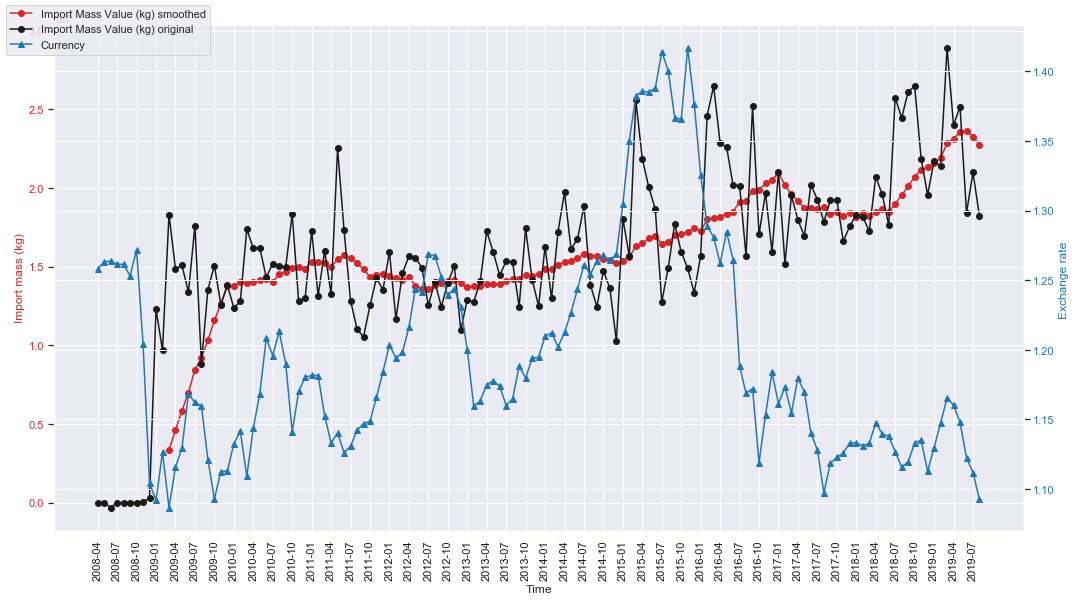

In [89]:
#plot graphs using data from previous cell

fig, ax1 = plt.subplots(figsize = (15,8))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Import mass (kg)', color=color)
ax1.plot(ts_imp_rmean.index, ts_imp_rmean.net_mass_kg_imp, color = color, marker = 'o', ls = None)
ax1.plot(ts_imp_rmean_w1.index, ts_imp_rmean_w1.net_mass_kg_imp, color = 'k', marker = 'o', ls = None)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Exchange rate ', color=color)  # we already handled the x-label with ax1
ax2.plot(ts_eur_rmean.index, ts_eur_rmean.month_euro_gbp, color=color, marker = '^', ls = None)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(ticks = ts_eur_rmean.index[::3], rotation=90)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.tick_params(axis='x', which='major', labelcolor='k', rotation=90)

labels = ['Import Mass Value (kg) smoothed', 'Import Mass Value (kg) original', 'Currency']
fig.legend(labels = labels, loc = 'upper left');

## A Toy Problem:

Hypothesis for vulnerability:

We define an industry as vulnerable based on the following assumptions:

1) If GBP goes up:
   (a) Assuming trade volume does not change, one would expect import value to decrease, since buying the same amount of goods
       as before would cost less. If however, trade value stays constant or increases, this suggests vulnerability.
       
   (b) Assuming trade volume does not change, one would expect export value to increase, since selling the same amount of goods
       as before would be more expensive for the buyer. If however, trade volume stays constant or decreases, this suggests            vulnerability.
       
    Want positive or 0 cross correlation 
       
2) If GBP goes down:
   (a) Assuming trade volume does not change, one would expect import value to increase, since buying the same amount of goods
       as before would cost more. If however, trade value stays constant or increases, this suggest vulnerability.
       
   (b) Assuming trade volume does not change, one would expect export value to decrease, since selling the same amount of goods
       as before would be less expensive for the buyer. If however, trade volume stays constant or increases, this suggests            vulnerability.
       
    Want negative cross or 0 correlation


### Imports, GBP down

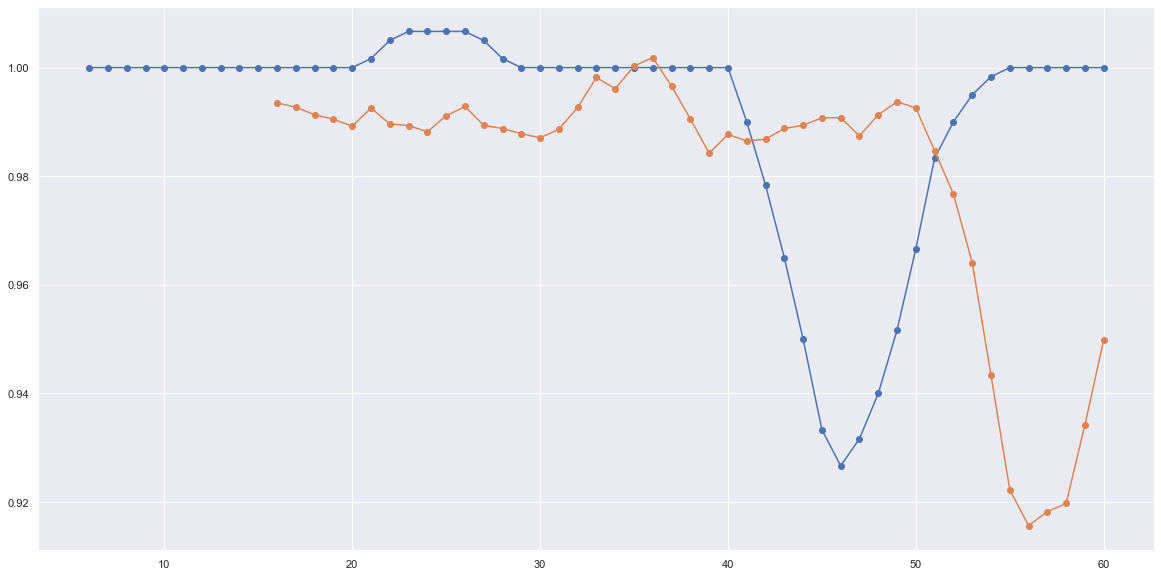

In [90]:
# toy dataset
months = np.arange(1,61)
slope1= -0.01
slope2 = 0.01

noise = np.random.normal(-0.01, 0.01, 60) # add a bit of noise

currency = np.ones(60)
currency[20:22] += -1*slope1*(months[20:22] - 20) 
currency[22:24] += -1*slope2*(months[22:24] - 24) 
currency[40:45] += slope1*(months[45:50] - 40) 
currency[45:50] += slope2*(months[45:50] - 50) 
currency = pd.Series(currency)

trade_imp = pd.Series(currency).shift(10) + noise

currency = rolling_statistic(currency, 6)
trade_imp = rolling_statistic(trade_imp, 6)

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(months, currency, '-o')
ax.plot(months, trade_imp, '-o')

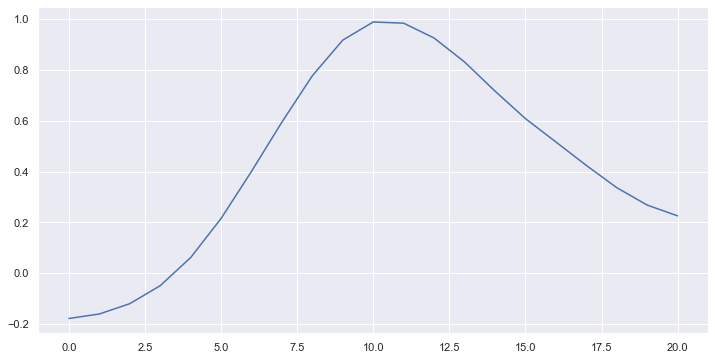

In [91]:
# plot cross-correlation
lag_range = np.arange(0,21)
corrcoef_list = [crosscorr_old(trade_imp,currency, lag, method = 'pearson') for lag in lag_range]

plt.figure(figsize = (12,6))
sns.lineplot(lag_range, corrcoef_list)
#plt.xlabel('Lag (months)')
#plt.ylabel('{} correlation coefficient'.format(method));
#plt.title('HS4 code: {}'.format(hs4_code));

### Imports, GBP up

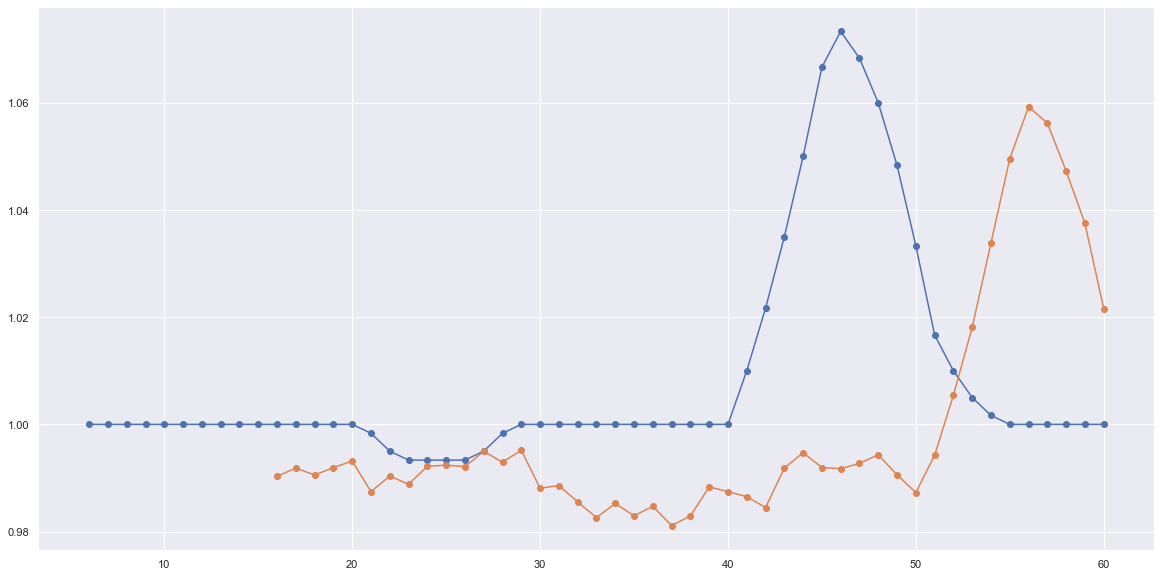

In [92]:
# toy dataset
months = np.arange(1,61)
slope1= -0.01
slope2 = 0.01

noise = np.random.normal(-0.01, 0.01, 60) # add a bit of noise

currency = np.ones(60)
currency[20:22] += slope1*(months[20:22] - 20) 
currency[22:24] += slope2*(months[22:24] - 24) 
currency[40:45] += -1*slope1*(months[45:50] - 40) 
currency[45:50] += -1*slope2*(months[45:50] - 50) 
currency = pd.Series(currency)

trade_imp = pd.Series(currency).shift(10) + noise

currency = rolling_statistic(currency, 6)
trade_imp = rolling_statistic(trade_imp, 6)

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(months, currency, '-o')
ax.plot(months, trade_imp, '-o')

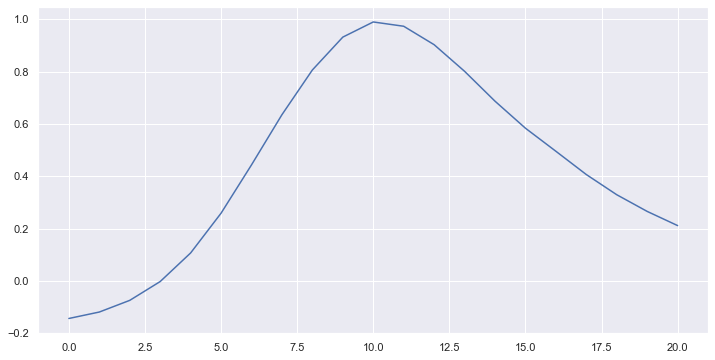

In [93]:
# plot cross-correlation
lag_range = np.arange(0,21)
corrcoef_list = [crosscorr_old(trade_imp,currency, lag, method = 'pearson') for lag in lag_range]

plt.figure(figsize = (12,6))
sns.lineplot(lag_range, corrcoef_list)
#plt.xlabel('Lag (months)')
#plt.ylabel('{} correlation coefficient'.format(method));
#plt.title('HS4 code: {}'.format(hs4_code));

### Exports, GBP down

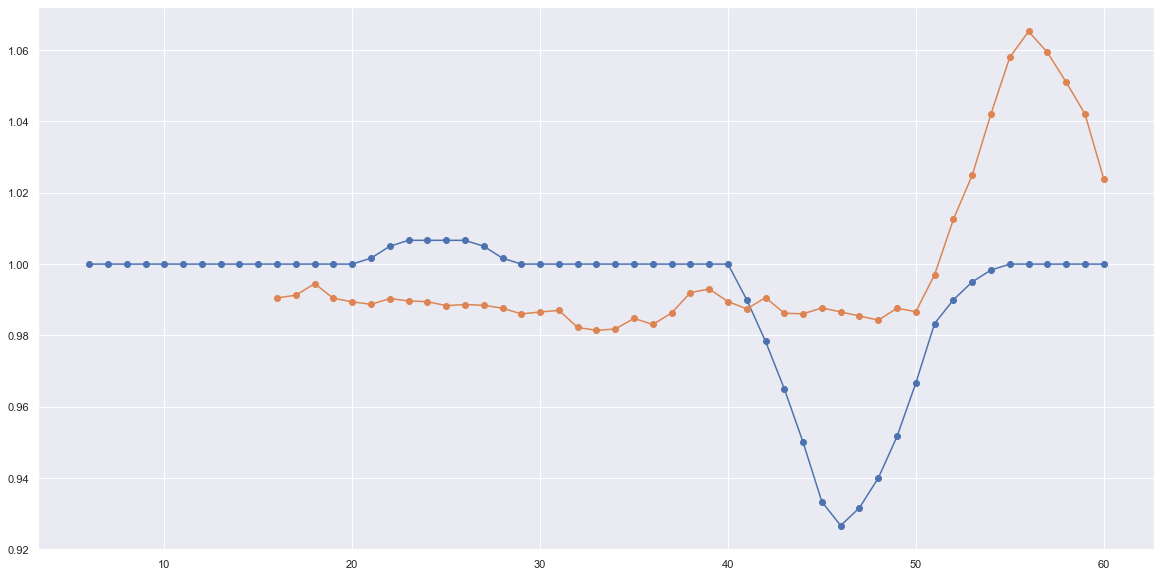

In [94]:
# toy dataset
months = np.arange(1,61)
slope1= -0.01
slope2 = 0.01

noise = np.random.normal(-0.01, 0.01, 60) # add a bit of noise

currency = np.ones(60)
currency[20:22] += -1*slope1*(months[20:22] - 20) 
currency[22:24] += -1*slope2*(months[22:24] - 24) 
currency[40:45] += slope1*(months[45:50] - 40) 
currency[45:50] += slope2*(months[45:50] - 50) 
currency = pd.Series(currency)

trade_imp = pd.Series((-1*(currency - 1))+1).shift(10) + noise

currency = rolling_statistic(currency, 6)
trade_imp = rolling_statistic(trade_imp, 6)

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(months, currency, '-o')
ax.plot(months, trade_imp, '-o')

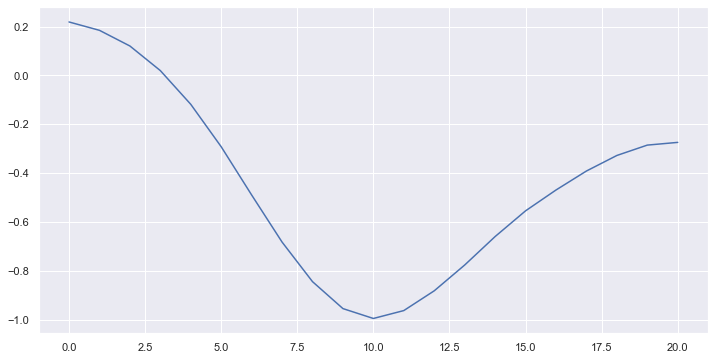

In [95]:
# plot cross-correlation
lag_range = np.arange(0,21)
corrcoef_list = [crosscorr_old(trade_imp,currency, lag, method = 'pearson') for lag in lag_range]

plt.figure(figsize = (12,6))
sns.lineplot(lag_range, corrcoef_list)
#plt.xlabel('Lag (months)')
#plt.ylabel('{} correlation coefficient'.format(method));
#plt.title('HS4 code: {}'.format(hs4_code));

### Exports, GBP up

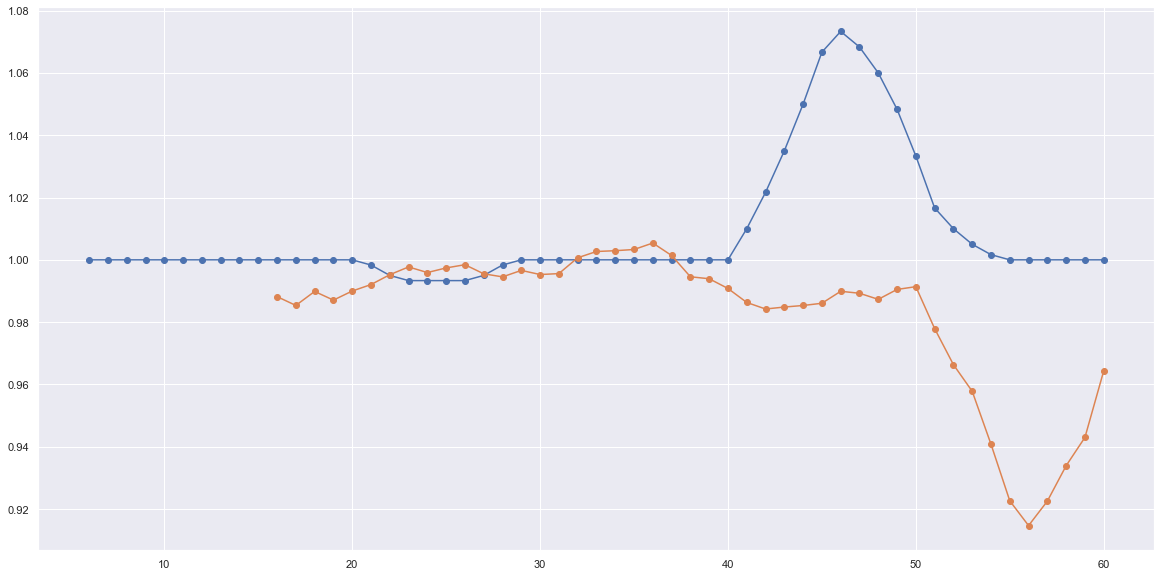

In [96]:
# toy dataset
months = np.arange(1,61)
slope1= -0.01
slope2 = 0.01

noise = np.random.normal(-0.01, 0.01, 60) # add a bit of noise

currency = np.ones(60)
currency[20:22] += slope1*(months[20:22] - 20) 
currency[22:24] += slope2*(months[22:24] - 24) 
currency[40:45] += -1*slope1*(months[45:50] - 40) 
currency[45:50] += -1*slope2*(months[45:50] - 50) 
currency = pd.Series(currency)

#trade_imp = pd.Series(currency).shift(10) + noise
trade_imp = pd.Series((-1*(currency - 1))+1).shift(10) + noise

currency = rolling_statistic(currency, 6)
trade_imp = rolling_statistic(trade_imp, 6)

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(months, currency, '-o')
ax.plot(months, trade_imp, '-o')

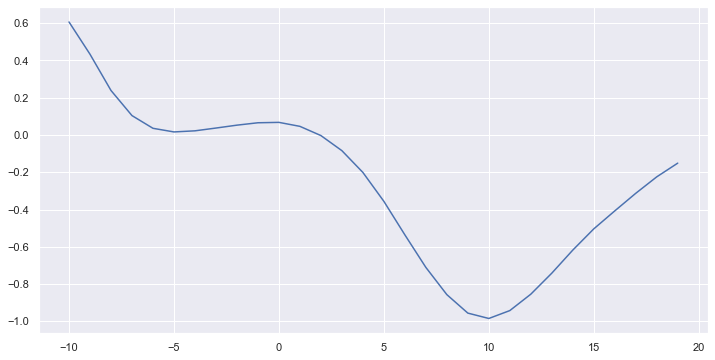

In [97]:
# plot cross-correlation
lag_range = np.arange(-10,20)
corrcoef_list = [crosscorr_old(trade_imp,currency, lag, method = 'pearson') for lag in lag_range]

plt.figure(figsize = (12,6))
sns.lineplot(lag_range, corrcoef_list)
#plt.xlabel('Lag (months)')
#plt.ylabel('{} correlation coefficient'.format(method));
#plt.title('HS4 code: {}'.format(hs4_code));

## Stationarity tests of time series data
- We have performed the augmented Dickey-Fuller test to check for stationarity of the time series data. Please check this [https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html](link) for documentation.

In [98]:

#X = pct_change_calculator(exchange_euro,period=1).dropna()
#result = adfuller(X)
#print('ADF Statistic: %f' % result[0])
#print('p-value: {}'.format(result[1]))
#print('Critical Values:')
#for key, value in result[4].items():
#    print('\t%s: %.3f' % (key, value))
hs4_codes = ['201', '203', '204', '206', '207', '210', '305', '401', '405', '406', '409', '701', '901', '902', '1004',
            '1006', '1107', '1501', '1515', '1601', '1602', '1604', '1703', '1704', '1806', '1902', '1905', '2001',
            '2007', '2008', '2103', '2104', '2105', '2106', '2201', '2202', '2203', '2204', '2206', '2208']

adfuller_df = pd.DataFrame(columns = ['p_value', 'feature', 'HS4_code'])
for hs4_code in hs4_codes:
    data = pd.read_csv('../data/processed/{}_trade_currency.csv'.format(hs4_code))
    cols = ['net_mass_kg_exp', 'net_mass_kg_imp', 'values_pounds_exp', 'values_pounds_imp', 'month_aud_gbp', 'month_pln_gbp',
       'month_cny_gbp', 'month_try_gbp', 'month_inr_gbp', 'month_euro_gbp',
       'month_jpy_gbp', 'month_sek_gbp', 'month_usd_gbp',
       'month_brl_gbp', 'month_ars_gbp']
    for col in cols:
        pval = adfuller(diff_calculator(data[col],period=1).dropna())[1]
        pval_df = pd.DataFrame([[pval, col, hs4_code]], columns = ['p_value', 'feature', 'HS4_code'])
        adfuller_df = adfuller_df.append(pval_df, ignore_index = True)
    

In [99]:
adfuller_df.loc[adfuller_df.p_value> 0.05, :].drop_duplicates('p_value')

,p_value,feature,HS4_code
14,0.063511,month_ars_gbp,201
332,0.180503,values_pounds_exp,1703
346,0.052037,net_mass_kg_imp,1704
348,0.144797,values_pounds_imp,1704
361,0.088143,net_mass_kg_imp,1806
363,0.108955,values_pounds_imp,1806
391,0.152878,net_mass_kg_imp,1905
393,0.162723,values_pounds_imp,1905


- Only in 8 cases we have p-values >0.5. HS4 code 1806 refers to chocolate and other food preparations containing cocoa. Let's take a look at the exchange rate of Argentinian Pesos to GBP below.

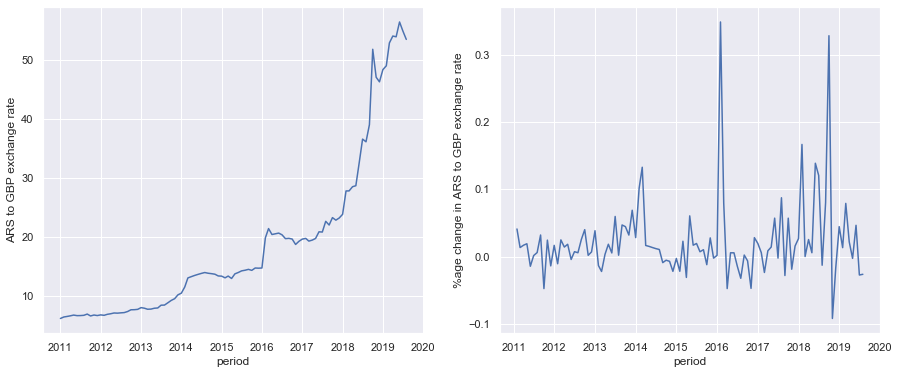

In [100]:
data['period'] = pd.to_datetime(data.period)
data = data.loc[data.period.dt.year > 2008, :]
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
sns.lineplot(data.period, data.month_ars_gbp, ax = ax1);
sns.lineplot(data.period, data.month_ars_gbp.pct_change(), ax = ax2);
ax1.set_ylabel('ARS to GBP exchange rate');
ax2.set_ylabel('%age change in ARS to GBP exchange rate');

## Plotting Currency-Mass Cross-Correlation with Time

In [101]:
vulnerable_hs4_codes = ['201', '901', '1604', '2001', '2103', '2105', '2201', '2206'] #1004

In [102]:
hs4_code = '201'
data = pd.read_csv('../data/processed/{}_trade_currency.csv'.format(hs4_code))

In [103]:
data.head()

,Unnamed: 0,period,month_aud_gbp,month_pln_gbp,month_cny_gbp,month_try_gbp,month_inr_gbp,month_euro_gbp,month_jpy_gbp,month_sek_gbp,...,month_hkd_gbp,month_dkk_gbp,month_brl_gbp,month_ars_gbp,HS4_code,year,net_mass_kg_exp,values_pounds_exp,net_mass_kg_imp,values_pounds_imp
0,0,2008-02,2.1512,4.7593,14.0709,2.3481,77.9060,1.3316,210.3432,12.4723,...,15.3121,9.9259,NaN,NaN,201,2008,2,10,18153,55331
1,1,2008-05,2.0697,4.2990,13.6956,2.4478,82.6798,1.2633,204.9599,11.7657,...,15.3190,9.4255,NaN,NaN,201,2008,10624,55176,38297,165011
2,2,2008-06,2.0669,4.2632,13.5596,2.4282,84.0899,1.2636,210.1669,11.8525,...,15.3478,9.4244,NaN,NaN,201,2008,8458,46145,47500,202582
3,3,2008-07,2.0662,4.1082,13.5902,2.4084,85.0406,1.2615,212.3982,11.9299,...,15.5067,9.4109,NaN,NaN,201,2008,23193,92546,-29535,-36309
4,4,2008-08,2.1400,4.1497,12.9429,2.2275,81.0301,1.2614,206.4774,11.8559,...,14.7490,9.4095,NaN,NaN,201,2008,10993,52461,48900,201362


## Hypothesis for vulnerability:

We define an industry as vulnerable based on the following assumptions:

- If GBP goes down (becomes weak):
   - Imports (volume) of a vulnerable industry should go down. Therefore the percent changes in exchange rate should be positively correlated with the per cent changes in the import volume. If the import volume either stays constant or goes up, then we'll say that that food industry is not vulnerable to changes in value of the pound.
   - Exports should increase if that industry is vulnerable because that item will now be cheaper in the country to which it is exported. Therefore changes in exports should be negatively correlated with changes in exchange rate.
   
- If GBP goes up (becomes stronger):
  - Imports (volume) of a vulnerable (or sensitive) industry should go up because you can now import more for the same price.


### Granger causality

In [104]:
method = 'pearson'
currency = 'euro'
statistic = 'mean'
trade_dir = 'imp'
change_type = 'diff'
window_size_mass = 1
window_size_exchange = 1

data = pd.read_csv('../data/processed/901_trade_currency.csv'.format(hs4_code))
hs4_df = compute_rs_and_change_mass(data, window_size_mass = window_size_mass ,
                                  window_size_exchange=window_size_exchange, statistic = statistic, 
                                        currency= currency, change_type = change_type)

In [105]:
x = hs4_df[['net_mass_kg_imp','month_euro_gbp']].dropna().values

In [106]:
grangercausalitytests(x, maxlag=20, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8118  , p=0.1806  , df_denom=132, df_num=1
ssr based chi2 test:   chi2=1.8529  , p=0.1734  , df=1
likelihood ratio test: chi2=1.8403  , p=0.1749  , df=1
parameter F test:         F=1.8118  , p=0.1806  , df_denom=132, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3960  , p=0.0951  , df_denom=129, df_num=2
ssr based chi2 test:   chi2=4.9777  , p=0.0830  , df=2
likelihood ratio test: chi2=4.8875  , p=0.0868  , df=2
parameter F test:         F=2.3960  , p=0.0951  , df_denom=129, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8310  , p=0.1449  , df_denom=126, df_num=3
ssr based chi2 test:   chi2=5.7981  , p=0.1219  , df=3
likelihood ratio test: chi2=5.6753  , p=0.1285  , df=3
parameter F test:         F=1.8310  , p=0.1449  , df_denom=126, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2719  , p=0.2847  

{1: ({'ssr_ftest': (1.8117580104369857, 0.18060463076851796, 132.0, 1),
   'ssr_chi2test': (1.852934328856008, 0.1734424998776249, 1),
   'lrtest': (1.8403333317573924, 0.1749118837559565, 1),
   'params_ftest': (1.8117580104369404, 0.1806046307685235, 132.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.3959759016671356, 0.09512660483005618, 129.0, 2),
   'ssr_chi2test': (4.97768636935498, 0.08300593359225147, 2),
   'lrtest': (4.887461137268474, 0.08683629768485938, 2),
   'params_ftest': (2.395975901667147, 0.09512660483005447, 129.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.8309770488471047, 0.1448832586521528, 126.0, 3),
   'ssr_chi2test': (5.798093988015832, 0.12185742120370494, 3),
   'lrtest': (5.675267961685677, 0.12852347401783573, 3),
   'params_ftest': (1.8309770488471064, 0.1448832586521528, 126.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

## Time-lagged cross correlation and hypothesis testing

In [107]:
def hs4_trade_partners(hs4_trade_cc, currency, trade_dir, method = 'pearson', statistic = 'mean',
                       change_type = 'pct_change', window_size_mass = 1, window_size_exchange = 1, sig_level = 0.1):

    lag_range = np.arange(0,21)
    pval_df_all_trade = pd.DataFrame(columns=['pval','corr_coeff','lag'])
    for hs4_code in hs4_trade_cc:
        data = pd.read_csv('../data/processed/{}_trade_currency.csv'.format(hs4_code))
        data['period'] = pd.to_datetime(data.period)
        data = data.loc[data.period.dt.year > 2008, :]
        hs4_df = compute_rs_and_change_mass(data, window_size_mass = window_size_mass ,
                                  window_size_exchange=window_size_exchange, statistic = statistic, 
                                        currency= currency, change_type = change_type)
        pval_list = [crosscorr(hs4_df['net_mass_kg_{}'.format(trade_dir)],hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[1] for lag in lag_range]
        crosscorr_list = [crosscorr(hs4_df['net_mass_kg_{}'.format(trade_dir)],hs4_df['month_{}_gbp'.format(currency)], lag, method = method)[0] for lag in lag_range]
        pval_df = pd.DataFrame(list(zip(pval_list, crosscorr_list, lag_range)), columns=['pval','corr_coeff','lag'])
        pval_df['HS4'] = hs4_code
        pval_df['currency'] = currency
        pval_df['trade_dir'] = trade_dir
        # Select rows with p values less than the signifance level
        pval_df = pval_df.loc[pval_df.pval < sig_level, :]
        pval_df_all_trade = pd.concat([pval_df_all_trade, pval_df], axis = 0, ignore_index=True, sort=False)
    return pval_df_all_trade

In [108]:
### Exports #####

method = 'pearson'
currency = 'euro'
statistic = 'mean'
trade_dir = 'exp'
change_type = 'pct_change'
window_size_mass = 1
window_size_exchange = 1
sig_level = 0.05

pval_df_all_exp = hs4_trade_partners(hs4_codes, currency=currency,trade_dir=trade_dir, sig_level=sig_level)

In [109]:
## Imports

method = 'pearson'
currency = 'euro'
statistic = 'mean'
trade_dir = 'imp'
change_type = 'pct_change'
window_size_mass = 1
window_size_exchange = 1
sig_level = 0.05

pval_df_all_imp = hs4_trade_partners(hs4_codes, currency=currency,trade_dir=trade_dir, sig_level=sig_level)

In [110]:
# Select rows with correlation coefficients greater than 0.2 => definition of vulnerability
vulnerable_imports_mass = pval_df_all_imp.loc[pval_df_all_imp.corr_coeff > 0.2, :].reset_index(drop=True)
vulnerable_exports_mass = pval_df_all_exp.loc[pval_df_all_exp.corr_coeff < -0.2, :].reset_index(drop=True)

In [111]:
vulnerable_imports_mass

,pval,corr_coeff,lag,HS4,currency,trade_dir
0,0.016388,0.216059,4,201,euro,imp
1,0.000195,0.346451,16,203,euro,imp
2,0.001710,0.294411,16,207,euro,imp
3,0.020726,0.212745,9,210,euro,imp
4,0.018940,0.222459,16,210,euro,imp
5,0.025957,0.211362,16,305,euro,imp
6,0.015036,0.220606,6,405,euro,imp
7,0.017193,0.214510,4,1601,euro,imp
8,0.011584,0.237785,15,1806,euro,imp
9,0.022618,0.205465,4,2001,euro,imp


- Some HS4 codes appear more than once in the above dataframe, because of multiple peaks that satisfy our vulnearbility criteria.
- We'll keep the first peak (with the smallest lag) and discard any other ones.

In [112]:
vulnerable_imports_mass = vulnerable_imports_mass.sort_values('lag').drop_duplicates('HS4', keep = 'first')
vulnerable_exports_mass = vulnerable_exports_mass.sort_values('lag').drop_duplicates('HS4', keep = 'first')

In [113]:
vulnerable_HS4_mass = pd.merge(vulnerable_imports_mass,vulnerable_exports_mass, how='outer',on='HS4', suffixes = ('_imp', '_exp'))
vulnerable_HS4_mass

,pval_imp,corr_coeff_imp,lag_imp,HS4,currency_imp,trade_dir_imp,pval_exp,corr_coeff_exp,lag_exp,currency_exp,trade_dir_exp
0,0.024991,0.201271,3,2105,euro,imp,NaN,NaN,NaN,NaN,NaN
1,0.016388,0.216059,4,201,euro,imp,NaN,NaN,NaN,NaN,NaN
2,0.017193,0.214510,4,1601,euro,imp,NaN,NaN,NaN,NaN,NaN
3,0.022618,0.205465,4,2001,euro,imp,NaN,NaN,NaN,NaN,NaN
4,0.015036,0.220606,6,405,euro,imp,0.005542,-0.252788,8,euro,exp
5,0.020726,0.212745,9,210,euro,imp,0.022738,-0.220081,20,euro,exp
6,0.023412,0.209470,10,2206,euro,imp,0.002010,-0.294041,19,euro,exp
7,0.011584,0.237785,15,1806,euro,imp,0.025865,-0.206883,11,euro,exp
8,0.000195,0.346451,16,203,euro,imp,NaN,NaN,NaN,NaN,NaN
9,0.001710,0.294411,16,207,euro,imp,NaN,NaN,NaN,NaN,NaN


- __18 food groups turn out to be vulnerable from the cross-correlation study with trade volume (mass).__

#### Which are the food groups that are vulnerable to both imports and exports (mass)?

In [114]:
set(vulnerable_imports_mass.HS4).intersection(set(vulnerable_exports_mass.HS4))

{'1806', '210', '2206', '405'}

### Plot time series of vulnerable food groups (trade volume)

In [115]:
def plot_ts(df, hs4_code, trade_dir = 'imp', currency = 'euro', lag=0):
    df['period'] = pd.to_datetime(df.period)
    df = df.loc[df.period.dt.year > 2008, :]
    
    fig, ax1 = plt.subplots(figsize = (15,6))
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('{} mass (kg)'.format(trade_dir+'ort'), color=color)
    ax1.plot(df['period'], df['net_mass_kg_{}'.format(trade_dir)].diff(), color = color, marker = 'o', ls = None)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Exchange rate ', color=color) 
    ax2.plot(df['period'], df['month_{}_gbp'.format(currency)].diff().shift(lag), color=color, marker = '^', ls = None)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.xticks(ticks = df.period[::3], rotation=90)
    fig.tight_layout()  
    ax1.tick_params(axis='x', which='major', labelcolor='k', rotation=90)
    labels = ['{} Mass Value (kg)'.format(trade_dir+'ort'), '{} shifted'.format(currency)]
    fig.legend(labels = labels)
    plt.title(hs4_code)

In [116]:
for hs4_code, lag in zip(vulnerable_imports_mass.HS4, vulnerable_imports_mass.lag):
    data = pd.read_csv('../data/processed/{}_trade_currency.csv'.format(hs4_code))
#    plot_ts(data, hs4_code = hs4_code, trade_dir = 'imp', lag = lag)

In [117]:
for hs4_code, lag in zip(vulnerable_exports_mass.HS4, vulnerable_exports_mass.lag):
    data = pd.read_csv('../data/processed/{}_trade_currency.csv'.format(hs4_code))
#    plot_ts(data, hs4_code = hs4_code,trade_dir = 'exp', lag = lag)

# Which are the vulnerable food groups?

In [118]:
# 40 HS4 codes
hs4_40 = [1905,401,406,210,1602,1604,1601,902,207,2007,2204,701,2202,201,2104,2103,2203,2008,901,203,405,2001,1806,2208,2105,305,2106,204,409,1515,1703,2206,206,1004,1501,1006,1107,1902,2201,1704]

# Lists of HS4 codes for each key import partners
hs4_imp_euro = [401,1004,1006,1501,1515,1602,1703,1806,1905,2007,2008,2104,406,1601,701,203,405,2208,1107,1704,2204,
                201,901,1604,2001,2103,2105,2201,2206]
hs4_imp_usd = [2103]
hs4_imp_aud = [210,2202,2106,204,901]
hs4_imp_ars = [201,902,2203,305,206,207,409]
hs4_imp_brl = [1902,901]
hs4_imp_dkk = [1604]
hs4_imp_pln = [1604]
hs4_imp_cny = [2001]
hs4_imp_inr = [2001]
hs4_imp_try = [2201]
hs4_imp_sek = [2206]
hs4_imp_jpy = [2206]

# Lists of HS4 codes for each key export partners
# xcd --> EUR and USD
# bbd -> USD
# all -> EUR
# aoa -> EUR and USD
# dza (algerian dinar) -> EUR

hs4_exp_euro = [401,1004,1006,1501,1515,1602,1703,1806,1905,2007,2008,2104,204,1902,409,201,1604,2001,2103,2105,2201,
                2206, 210,305,1601,203,405, 207,206, 406]
hs4_exp_aud = [902,2202,2203,2106,2208,1107,1704,2206]
hs4_exp_hkd = [2204]
hs4_exp_ars = [901]
hs4_exp_usd = [210,305,1601,203,405, 701,206]

In [119]:
# test run of the function `compute_crosscorr_and_pval_hs4'
compute_crosscorr_and_pval_hs4(hs4_imp_brl, currency = 'brl', trade_dir ='imp')

,pval,corr_coeff,lag,HS4,currency,trade_dir
0,0.016751,-0.250220,5,1902.0,brl,imp
1,0.008666,0.275179,6,1902.0,brl,imp


#### Vulnerable food groups: Cross-correlation between trade volume/mass and exchange rates

In [120]:
def find_shortest_lag(df):
    out_df = df.sort_values('lag', ascending = True)
    return out_df.iloc[0, :]

In [121]:
#---parameter list------
method = 'pearson'
statistic = 'mean'
change_type = 'pct_change'
window_size_mass = 1
window_size_value = 1
window_size_exchange = 1
sig_level = 0.05
plot = False
#------------------------


## Imports

hs4_imp_cur_list = [hs4_imp_euro, hs4_imp_usd, hs4_imp_aud, hs4_imp_ars, hs4_imp_brl, hs4_imp_dkk, hs4_imp_pln, hs4_imp_cny,
hs4_imp_inr ,hs4_imp_try, hs4_imp_sek, hs4_imp_jpy]
cur_list_imp = ['euro', 'usd', 'aud', 'ars', 'brl', 'dkk', 'pln', 'cny', 'inr', 'try', 'sek', 'jpy']

hs4_vul_mass_imp_df = pd.DataFrame(columns = ['pval', 'corr_coeff', 'lag', 'HS4', 'currency', 'trade_dir'])
for lst, cur in zip(hs4_imp_cur_list, cur_list_imp):
    df = compute_crosscorr_and_pval_hs4(lst, currency = cur, trade_dir ='imp', sig_level = sig_level, mass_or_value = 'mass')
    hs4_vul_mass_imp_df = pd.concat([hs4_vul_mass_imp_df, df], axis = 0, sort =False)

## Exports

hs4_exp_cur_list = [hs4_exp_euro, hs4_exp_aud, hs4_exp_hkd, hs4_exp_ars, hs4_exp_usd]
cur_list_exp = ['euro', 'aud', 'hkd', 'ars', 'usd']

hs4_vul_mass_exp_df = pd.DataFrame(columns = ['pval', 'corr_coeff', 'lag', 'HS4', 'currency', 'trade_dir'])
for lst, cur in zip(hs4_exp_cur_list, cur_list_exp):
    df = compute_crosscorr_and_pval_hs4(lst, currency = cur, trade_dir ='exp', sig_level= sig_level, mass_or_value = 'mass')
    hs4_vul_mass_exp_df = pd.concat([hs4_vul_mass_exp_df, df], axis = 0, sort =False)

In [122]:
# Select rows with correlation coefficients greater than 0.2 => definition of vulnerability
vulnerable_imports_mass = hs4_vul_mass_imp_df.loc[hs4_vul_mass_imp_df.corr_coeff > 0.2, :].reset_index(drop=True)
vulnerable_exports_mass = hs4_vul_mass_exp_df.loc[hs4_vul_mass_exp_df.corr_coeff < -0.2, :].reset_index(drop=True)

vulnerable_imports_mass = vulnerable_imports_mass.set_index(['currency', 'HS4'])
vulnerable_exports_mass = vulnerable_exports_mass.set_index(['currency', 'HS4'])

temp_m_imp = {}
temp_m_exp = {}
for cur, newdf in vulnerable_imports_mass.groupby(['currency', 'HS4'], level = 0):    
    temp_m_imp[cur] = find_shortest_lag(newdf)
for cur, newdf in vulnerable_exports_mass.groupby(['currency', 'HS4'], level = 0):    
    temp_m_exp[cur] = find_shortest_lag(newdf)

vulnerable_imports_mass = pd.DataFrame.from_dict(temp_m_imp, orient = 'index').reset_index()
vulnerable_exports_mass = pd.DataFrame.from_dict(temp_m_exp, orient = 'index').reset_index()
vulnerable_imports_mass.columns = ['currency', 'HS4', 'pval', 'corr_coeff', 'lag', 'trade_dir']
vulnerable_exports_mass.columns = ['currency', 'HS4', 'pval', 'corr_coeff', 'lag', 'trade_dir']

vulnerable_imports_mass.loc[:, 'HS4'] = vulnerable_imports_mass.HS4.astype(int)
vulnerable_exports_mass.loc[:, 'HS4'] = vulnerable_exports_mass.HS4.astype(int)

#### Vulnerable food groups: Cross-correlation between trade values and exchange rates

In [123]:
## Imports

hs4_vul_value_imp_df = pd.DataFrame(columns = ['pval', 'corr_coeff', 'lag', 'HS4', 'currency', 'trade_dir'])
for lst, cur in zip(hs4_imp_cur_list, cur_list_imp):
    df = compute_crosscorr_and_pval_hs4(lst, currency = cur, trade_dir ='imp', sig_level=0.05, mass_or_value = 'value')
    hs4_vul_value_imp_df = pd.concat([hs4_vul_value_imp_df, df], axis = 0, sort =False)

## Exports

hs4_vul_value_exp_df = pd.DataFrame(columns = ['pval', 'corr_coeff', 'lag', 'HS4', 'currency', 'trade_dir'])
for lst, cur in zip(hs4_exp_cur_list, cur_list_exp):
    df = compute_crosscorr_and_pval_hs4(lst, currency = cur, trade_dir ='exp', sig_level=0.05, mass_or_value = 'value')
    hs4_vul_value_exp_df = pd.concat([hs4_vul_value_exp_df, df], axis = 0, sort =False)

In [124]:
# Select rows with correlation coefficients greater than 0.2 => definition of vulnerability
vulnerable_imports_trade = hs4_vul_value_imp_df.loc[hs4_vul_value_imp_df.corr_coeff > 0.2, :].reset_index(drop=True)
vulnerable_exports_trade = hs4_vul_value_exp_df.loc[hs4_vul_value_exp_df.corr_coeff < -0.2, :].reset_index(drop=True)

vulnerable_imports_trade = vulnerable_imports_trade.set_index(['currency', 'HS4'])
vulnerable_exports_trade = vulnerable_exports_trade.set_index(['currency', 'HS4'])

temp_t_imp = {}
temp_t_exp = {}
for cur, newdf in vulnerable_imports_trade.groupby(['currency', 'HS4'], level = 0):    
    temp_t_imp[cur] = find_shortest_lag(newdf)
for cur, newdf in vulnerable_exports_trade.groupby(['currency', 'HS4'], level = 0):    
    temp_t_exp[cur] = find_shortest_lag(newdf)

vulnerable_imports_trade = pd.DataFrame.from_dict(temp_t_imp, orient = 'index').reset_index()
vulnerable_exports_trade = pd.DataFrame.from_dict(temp_t_exp, orient = 'index').reset_index()
vulnerable_imports_trade.columns = ['currency', 'HS4', 'pval', 'corr_coeff', 'lag', 'trade_dir']
vulnerable_exports_trade.columns = ['currency', 'HS4', 'pval', 'corr_coeff', 'lag', 'trade_dir']



vulnerable_imports_trade.loc[:, 'HS4'] = vulnerable_imports_trade.HS4.astype(int)
vulnerable_exports_trade.loc[:, 'HS4'] = vulnerable_exports_trade.HS4.astype(int)

#### Common vulnerable food groups

In [125]:
# Merge imports and exports data by outer join
vulnerable_hs4_trade = pd.merge(vulnerable_imports_trade, vulnerable_exports_trade, 
                               how='outer', on='HS4',  suffixes = ('_imp', '_exp')).reset_index(drop=True)
vulnerable_hs4_trade

,currency_imp,HS4,pval_imp,corr_coeff_imp,lag_imp,trade_dir_imp,currency_exp,pval_exp,corr_coeff_exp,lag_exp,trade_dir_exp
0,ars,305,0.009499,0.281454,19.0,imp,NaN,NaN,NaN,NaN,NaN
1,ars,409,0.008572,0.281812,17.0,imp,NaN,NaN,NaN,NaN,NaN
2,ars,902,0.042163,0.205692,5.0,imp,NaN,NaN,NaN,NaN,NaN
3,ars,2203,0.040933,0.203803,2.0,imp,NaN,NaN,NaN,NaN,NaN
4,aud,210,0.004678,0.266601,16.0,imp,NaN,NaN,NaN,NaN,NaN
5,brl,1902,0.017569,0.249813,6.0,imp,NaN,NaN,NaN,NaN,NaN
6,euro,201,0.025316,0.201645,4.0,imp,NaN,NaN,NaN,NaN,NaN
7,euro,203,0.000037,0.380978,16.0,imp,usd,0.014604,-0.223385,8.0,exp
8,euro,405,0.014867,0.229634,15.0,imp,euro,0.008708,-0.239496,8.0,exp
9,euro,405,0.014867,0.229634,15.0,imp,usd,0.002033,-0.280107,8.0,exp


In [143]:
dict_hs4_codes = {201:'fresh beef', 202:'frozen beef', 203:'pork', 204:'sheep and goat meat',
                  206:'edible offal excl. poultry', 207:'poultry (incl. edible offal)',
                  210:'salted/dried/smoked meat and offal', 305:'salted/dried/smoked fish',
                  401:'unsweetened milk cream', 405:'dairy:butter/fats/oils/spreads', 406:'cheese/curd',
                  409:'natural honey', 701:'fresh potatoes', 901:'coffee', 902:'tea', 1004:'oats', 1006:'rice',
                  1107:'malt', 1501:'pig/poultry fat', 1515:'vegetable fats and oils', 1601:'sausages/processed meats',
                  1602:'prep. preserved meat meatoffal', 1604:'prep. preserved fish/fisheggs', 1703:'molasses',
                  1704:'sugar confec. excl. cocoa', 1806:'chocolate prep. incl. cocoa', 1902:'pasta/noodles',
                  1905:'bread/biscuits/cakes/pastry', 2001:'prep. preserved veg/fruit/nuts',
                  2007:'jam/jelly, fruit/nut paste', 2008:'prep. preserved fruit/nuts notinvinegar',2103:'sauces and condiments',
                  2104:'soup_broth', 2105:'ice-cream', 2106:'prep_foods_misc', 2201:'unsweetened water',
                  2202:'soft drinks excl. fruit juice', 2203:'beer', 2204:'wine', 2206:'fermented drinks',
                  2208:'spirits and liqueurs'}

In [127]:
# Merge imports and exports data by outer join mass
vulnerable_hs4_mass = pd.merge(vulnerable_imports_mass, vulnerable_exports_mass, 
                               how='outer', on='HS4',  suffixes = ('_imp', '_exp')).reset_index(drop=True)
vulnerable_hs4_mass

,currency_imp,HS4,pval_imp,corr_coeff_imp,lag_imp,trade_dir_imp,currency_exp,pval_exp,corr_coeff_exp,lag_exp,trade_dir_exp
0,ars,305,0.002916,0.320932,19.0,imp,NaN,NaN,NaN,NaN,NaN
1,ars,902,0.025817,0.220691,1.0,imp,aud,0.022124,-0.221064,20.0,exp
2,ars,2203,0.040048,0.216881,13.0,imp,NaN,NaN,NaN,NaN,NaN
3,aud,210,0.008127,0.242586,9.0,imp,euro,0.022738,-0.220081,20.0,exp
4,aud,210,0.008127,0.242586,9.0,imp,usd,0.021120,-0.219670,17.0,exp
5,aud,2202,0.022507,0.208182,7.0,imp,aud,0.028270,-0.212128,20.0,exp
6,brl,1902,0.008666,0.275179,6.0,imp,NaN,NaN,NaN,NaN,NaN
7,euro,201,0.016388,0.216059,4.0,imp,NaN,NaN,NaN,NaN,NaN
8,euro,203,0.000195,0.346451,16.0,imp,NaN,NaN,NaN,NaN,NaN
9,euro,405,0.015036,0.220606,6.0,imp,euro,0.005542,-0.252788,8.0,exp


### Vulnerable HS4 codes common to both trade volume and trade value

In [128]:
#intersection
common_vul_mass_trade =  set(vulnerable_hs4_mass.HS4.astype(int)).intersection(set(vulnerable_hs4_trade.HS4.astype(int)))
for code in common_vul_mass_trade:
    print(code, dict_hs4_codes[code])

1604 prep. preserved fish/fisheggs
902 tea
201 fresh beef
203 pork
1004 oats
1902 pasta/noodles
1806 chocolate prep. incl. cocoa
305 salted/dried/smoked fish
210 salted/dried/smoked meat and offal
2001 prep_pres_veg_fruit_nuts
405 dairy:butter/fats/oils/spreads
2008 prep. preserved fruit nuts notinvinegar
2203 beer
2206 fermented drinks


### Vulnerable HS4 codes common to both imports and exports

In [129]:
# Join the trade and mass df's by imports and exports
vulnerable_hs4_imp = pd.merge(vulnerable_imports_trade, vulnerable_imports_mass, 
                               how='outer', on='HS4',  suffixes = ('_trade', '_mass')).reset_index(drop=True)
vulnerable_hs4_exp = pd.merge(vulnerable_exports_trade, vulnerable_exports_mass, 
                               how='outer', on='HS4',  suffixes = ('_trade', '_mass')).reset_index(drop=True)

In [130]:
## Intersection
d1 = {}
common_vul_imp_exp = set(vulnerable_hs4_imp.HS4.astype(int)).intersection(set(vulnerable_hs4_exp.HS4.astype(int)))
for code in common_vul_imp_exp:
    d1[code] = dict_hs4_codes[code]

pd.DataFrame.from_dict(d1, orient='index', columns= ['Food group'])

,Food group
1602,prep. preserved meat meatoffal
902,tea
203,pork
1004,oats
1806,chocolate prep. incl. cocoa
210,salted/dried/smoked meat and offal
405,dairy:butter/fats/oils/spreads
2202,soft drinks excl. fruit juice
2206,fermented drinks


In [131]:
for code in set(common_vul_imp_exp).intersection(set(common_vul_mass_trade)):
    print(code, dict_hs4_codes[code])

902 tea
203 pork
1004 oats
1806 chocolate prep. incl. cocoa
210 salted/dried/smoked meat and offal
405 dairy:butter/fats/oils/spreads
2206 fermented drinks


## Plots for report

In [144]:
data_2206 = pd.read_csv('../data/processed/2206_trade_currency.csv')
data_2206['period'] = pd.to_datetime(data_2206.period)
data_2206 = data_2206.loc[data_2206.period.dt.year > 2008, :]

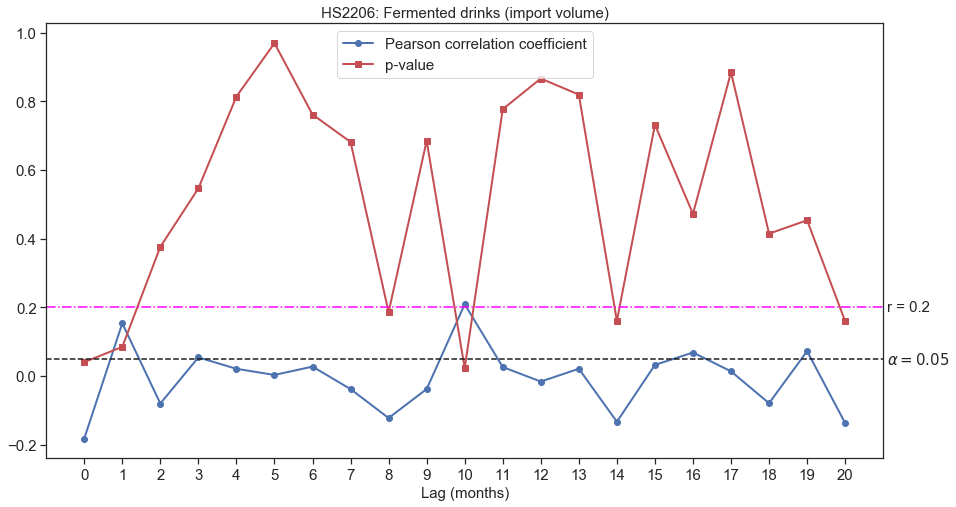

In [145]:
hs4_2206_df = compute_rs_and_change_mass(data_2206, window_size_value = 1 ,
                                  window_size_exchange=1, statistic = 'mean', 
                                        currency= 'euro', change_type = 'pct_change')

lag_range = np.arange(0,21)
merged_hs4_df = pd.merge(hs4_2206_df[['net_mass_kg_imp']].dropna(), hs4_2206_df[['month_euro_gbp']].dropna(), on = 'period')
corrcoef_list = [crosscorr(merged_hs4_df['net_mass_kg_imp'],merged_hs4_df['month_euro_gbp'], lag, method = method)[0] for lag in lag_range]
pval_list = [crosscorr(merged_hs4_df['net_mass_kg_imp'],merged_hs4_df['month_euro_gbp'], lag, method = method)[1] for lag in lag_range]

sns.set_style("ticks")
plt.figure(figsize = (15,8))
plt.plot(lag_range, corrcoef_list, 'bo-', label = 'Pearson correlation coefficient', lw=2);
plt.plot(lag_range, pval_list, 'rs-', label = 'p-value', lw=2);
plt.axhline(0.05, ls='--', color='k');
plt.axhline(0.2, ls='-.', color='magenta');
plt.xlabel('Lag (months)', fontsize = 15);
#plt.ylabel('Pearson correlation coefficient', fontsize = 15);
plt.title('HS2206: Fermented drinks (import volume)', fontsize = 15);
plt.text(21.1,0.05,r'$\alpha=0.05$', fontsize=15, verticalalignment='center');
plt.text(21.1,0.2,r'r = 0.2', fontsize=15, verticalalignment='center');
plt.xticks(ticks=np.arange(21), fontsize = 15)
plt.yticks(fontsize = 15);
plt.legend(fontsize = 15);
plt.savefig('crosscorr_2206_imp.png', dpi=150)

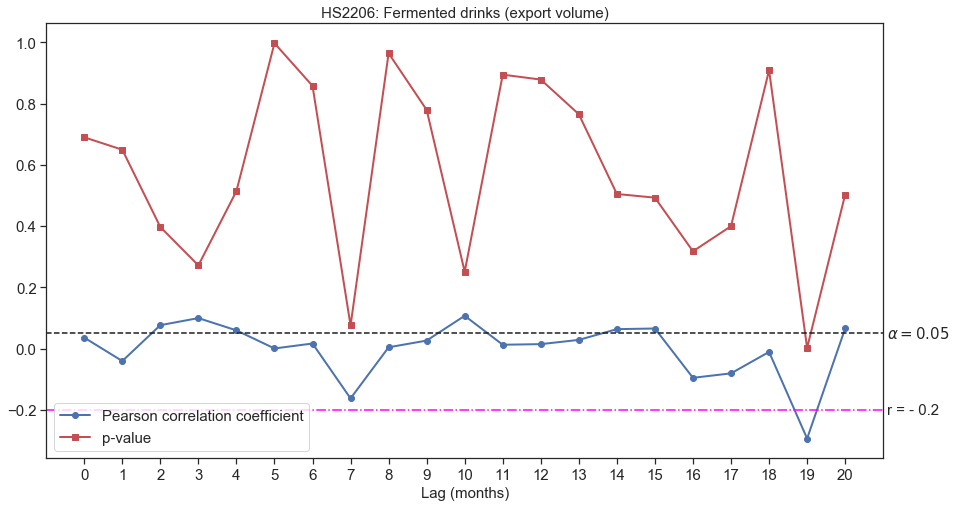

In [146]:
hs4_2206_df = compute_rs_and_change_mass(data_2206, window_size_value = 1 ,
                                  window_size_exchange=1, statistic = 'mean', 
                                        currency= 'euro', change_type = 'pct_change')

sns.set_style("ticks")
lag_range = np.arange(0,21)
merged_hs4_df = pd.merge(hs4_2206_df[['net_mass_kg_exp']].dropna(), hs4_2206_df[['month_euro_gbp']].dropna(), on = 'period')
corrcoef_list = [crosscorr(merged_hs4_df['net_mass_kg_exp'],merged_hs4_df['month_euro_gbp'], lag, method = method)[0] for lag in lag_range]
pval_list = [crosscorr(merged_hs4_df['net_mass_kg_exp'],merged_hs4_df['month_euro_gbp'], lag, method = method)[1] for lag in lag_range]
plt.figure(figsize = (15,8))
plt.plot(lag_range, corrcoef_list, 'bo-', label = 'Pearson correlation coefficient', lw=2);
plt.plot(lag_range, pval_list, 'rs-', label = 'p-value', lw=2);
plt.axhline(0.05, ls='--', color='k');
plt.axhline(-0.2, ls='-.', color='magenta');

plt.xlabel('Lag (months)', fontsize = 15);
#plt.ylabel('Pearson correlation coefficient', fontsize = 15);
plt.title('HS2206: Fermented drinks (export volume)', fontsize = 15);
plt.text(21.1,0.05,r'$\alpha=0.05$', fontsize=15, verticalalignment='center');
plt.text(21.1,-0.2,r'r = - 0.2', fontsize=15, verticalalignment='center');
plt.xticks(ticks=np.arange(21), fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15);
plt.savefig('crosscorr_2206_exp.png', dpi=150)

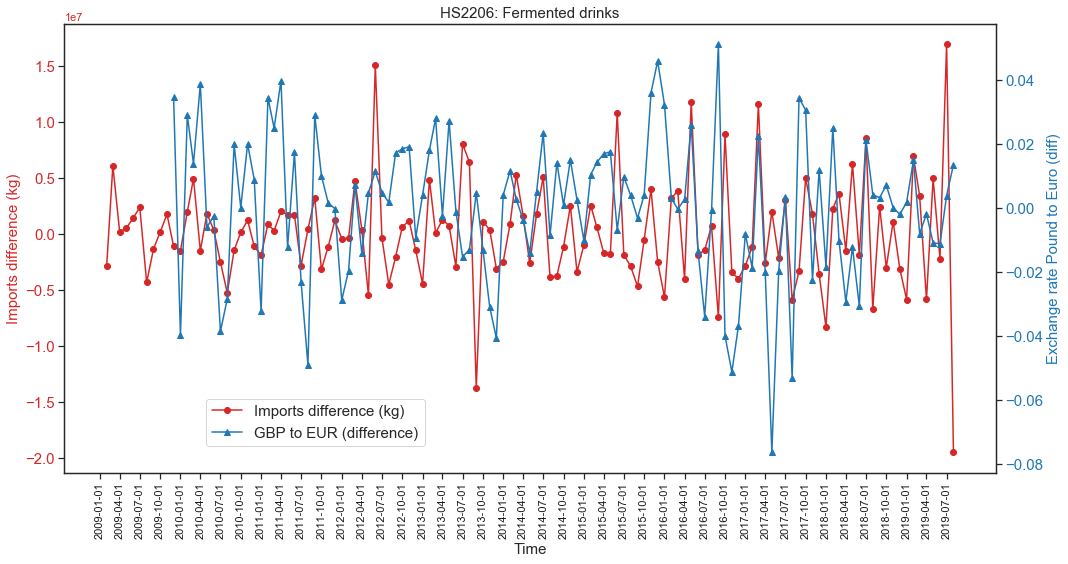

In [159]:
sns.set_style("ticks")
lag = 10

fig, ax1 = plt.subplots(figsize = (15,8))
color = 'tab:red'
ax1.set_xlabel('Time', fontsize = 15)
ax1.set_ylabel('Imports difference (kg)', color=color, fontsize = 15)
ax1.plot(data_2206['period'], data_2206['net_mass_kg_imp'].diff(), color = color, marker = 'o', ls = None)
ax1.tick_params(axis='y', labelcolor=color, labelsize = 15)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Exchange rate Pound to Euro (diff)', color=color, fontsize = 15) 
ax2.plot(data_2206['period'], data_2206['month_euro_gbp'].diff().shift(lag), color=color, marker = '^', ls = None)
ax2.tick_params(axis='y', labelcolor=color, labelsize = 15)
plt.xticks(ticks = data_2206.period[::3], rotation=90, fontsize = 15)
fig.tight_layout()  
ax1.tick_params(axis='x', which='major', labelcolor='k', rotation=90)
labels = ['Imports difference (kg)', 'GBP to EUR (difference)']
fig.legend(labels = labels, bbox_to_anchor=(0.4, 0.3), fontsize = 15)
plt.title('HS2206: Fermented drinks', fontsize = 15);
plt.tight_layout()
plt.savefig('ts_2206_cross_corr.png', dpi=150)

### Tables for report

In [148]:
tab1 = vulnerable_hs4_imp[['HS4', 'currency_trade', 'corr_coeff_trade', 'lag_trade', 'currency_mass', 'corr_coeff_mass', 'lag_mass']]
tab1.loc[:, 'description'] = tab1.HS4.apply(lambda c: dict_hs4_codes[c])
tab1.loc[:, 'HS4'] = tab1.loc[:,'HS4'].apply(lambda c: 'HS'+'0'+str(c) if len(str(c))<4 else 'HS'+str(c))
tab1.loc[:, 'corr_coeff_trade'] = tab1.loc[:, 'corr_coeff_trade'].apply(lambda val: round(val,2))
tab1.loc[:, 'corr_coeff_mass'] = tab1.loc[:, 'corr_coeff_mass'].apply(lambda val: round(val,2))
tab1.loc[:,:] = tab1.loc[:,:].fillna('N/A')
tab1.loc[:,'currency_trade'] = tab1.loc[:,'currency_trade'].apply(lambda cur: cur[:3].upper() if cur == 'euro' else str(cur).upper())
tab1.loc[:,'currency_mass'] = tab1.loc[:,'currency_mass'].apply(lambda cur: cur[:3].upper() if cur == 'euro' else str(cur).upper())

tab1 = tab1.rename(columns = {'corr_coeff_trade': 'Pearsonr_value', 'corr_coeff_mass': 'Pearsonr_mass', 
                       'lag_trade': 'lag_value(months)', 'lag_mass': 'lag_mass(months)'})
tab1 = tab1.sort_values('HS4')
tab1.drop(['description'], axis = 1).to_csv('../data/processed/vul_imp_tab.csv',   index=False)

In [149]:
tab1

,HS4,currency_trade,Pearsonr_value,lag_value(months),currency_mass,Pearsonr_mass,lag_mass(months),description
6,HS0201,EUR,0.2,4,EUR,0.22,4,fresh beef
7,HS0203,EUR,0.38,16,EUR,0.35,16,pork
4,HS0210,AUD,0.27,16,AUD,0.24,9,salted/dried/smoked meat and offal
0,HS0305,ARS,0.28,19,ARS,0.32,19,salted/dried/smoked fish
8,HS0405,EUR,0.23,15,EUR,0.22,6,dairy:butter/fats/oils/spreads
9,HS0406,EUR,0.21,15,N/A,N/A,N/A,cheese/curd
1,HS0409,ARS,0.28,17,N/A,N/A,N/A,natural honey
2,HS0902,ARS,0.21,5,ARS,0.22,1,tea
10,HS1004,EUR,0.22,17,N/A,N/A,N/A,oats
15,HS1601,N/A,N/A,N/A,EUR,0.21,4,sausages/processed meats


In [155]:
tab2 = vulnerable_hs4_exp[['HS4', 'currency_trade', 'corr_coeff_trade', 'lag_trade', 'currency_mass', 'corr_coeff_mass', 'lag_mass']]
tab2.loc[:, 'description'] = tab2.HS4.apply(lambda c: dict_hs4_codes[c])
tab2.loc[:, 'HS4'] = tab2.loc[:,'HS4'].apply(lambda c: 'HS'+'0'+str(c) if len(str(c))<4 else 'HS'+str(c))
tab2.loc[:, 'corr_coeff_trade'] = tab2.loc[:, 'corr_coeff_trade'].apply(lambda val: round(val,2))
tab2.loc[:, 'corr_coeff_mass'] = tab2.loc[:, 'corr_coeff_mass'].apply(lambda val: round(val,2))

tab2.loc[:,:] = tab2.loc[:,:].fillna('N/A')
tab2.loc[:,'currency_trade'] = tab2.loc[:,'currency_trade'].apply(lambda cur: cur[:3].upper() if cur == 'euro' else str(cur).upper())
tab2.loc[:,'currency_mass'] = tab2.loc[:,'currency_mass'].apply(lambda cur: cur[:3].upper() if cur == 'euro' else str(cur).upper())

tab2 = tab2.rename(columns = {'corr_coeff_trade': 'Pearsonr_value', 'corr_coeff_mass': 'Pearsonr_mass', 
                       'lag_trade': 'lag_value(months)', 'lag_mass': 'lag_mass(months)'})
tab2 = tab2.sort_values('HS4')
tab2.drop(['description'], axis = 1).to_csv('../data/processed/vul_exp_tab.csv',   index=False)

In [156]:
tab2

,HS4,currency_trade,Pearsonr_value,lag_value(months),currency_mass,Pearsonr_mass,lag_mass(months),description
13,HS0203,USD,-0.22,8,N/A,N/A,N/A,pork
2,HS0207,EUR,-0.21,2,N/A,N/A,N/A,poultry (incl. edible offal)
17,HS0210,N/A,N/A,N/A,USD,-0.22,17,salted/dried/smoked meat and offal
16,HS0210,N/A,N/A,N/A,EUR,-0.22,20,salted/dried/smoked meat and offal
3,HS0405,EUR,-0.24,8,EUR,-0.25,8,dairy:butter/fats/oils/spreads
4,HS0405,EUR,-0.24,8,USD,-0.29,8,dairy:butter/fats/oils/spreads
5,HS0405,USD,-0.28,8,EUR,-0.25,8,dairy:butter/fats/oils/spreads
6,HS0405,USD,-0.28,8,USD,-0.29,8,dairy:butter/fats/oils/spreads
14,HS0902,N/A,N/A,N/A,AUD,-0.22,20,tea
7,HS1004,EUR,-0.27,11,EUR,-0.22,11,oats


In [152]:
vul_hs4_imp_common = vulnerable_hs4_imp.dropna().reset_index()
vul_hs4_imp_common['description'] = vul_hs4_imp_common.loc[:,'HS4'].apply(lambda c: dict_hs4_codes[c])

vul_hs4_imp_common = vul_hs4_imp_common[['HS4', 'description']].sort_values('HS4')
vul_hs4_imp_common.loc[:, 'HS4'] = vul_hs4_imp_common.loc[:,'HS4'].apply(lambda c: 'HS'+'0'+str(c) if len(str(c))<4 else 'HS'+str(c))
vul_hs4_imp_common = vul_hs4_imp_common.drop_duplicates().reset_index(drop=True)

vul_hs4_imp_common.to_csv('../data/processed/mass_value_common_vul_codes_imp.csv', index = False)
vul_hs4_imp_common

,HS4,description
0,HS0201,fresh beef
1,HS0203,pork
2,HS0210,salted/dried/smoked meat and offal
3,HS0305,salted/dried/smoked fish
4,HS0405,dairy:butter/fats/oils/spreads
5,HS0902,tea
6,HS1806,chocolate prep. incl. cocoa
7,HS1902,pasta/noodles
8,HS2001,prep. preserved veg/fruit/nuts
9,HS2203,beer


In [153]:
vul_hs4_exp_common = vulnerable_hs4_exp.dropna().reset_index()
vul_hs4_exp_common['description'] = vul_hs4_exp_common.loc[:,'HS4'].apply(lambda c: dict_hs4_codes[c])

vul_hs4_exp_common = vul_hs4_exp_common[['HS4', 'description']].sort_values('HS4')
vul_hs4_exp_common.loc[:, 'HS4'] = vul_hs4_exp_common.loc[:,'HS4'].apply(lambda c: 'HS'+'0'+str(c) if len(str(c))<4 else 'HS'+str(c))
vul_hs4_exp_common = vul_hs4_exp_common.drop_duplicates().reset_index(drop=True)
vul_hs4_exp_common.to_csv('mass_value_common_vul_codes_exp.csv', index = False)
vul_hs4_exp_common

,HS4,description
0,HS0405,dairy:butter/fats/oils/spreads
1,HS1004,oats
2,HS1604,prep. preserved fish/fisheggs
3,HS1806,chocolate prep. incl. cocoa
4,HS2008,prep. preserved fruit/nuts notinvinegar
5,HS2206,fermented drinks


## Plot for slides

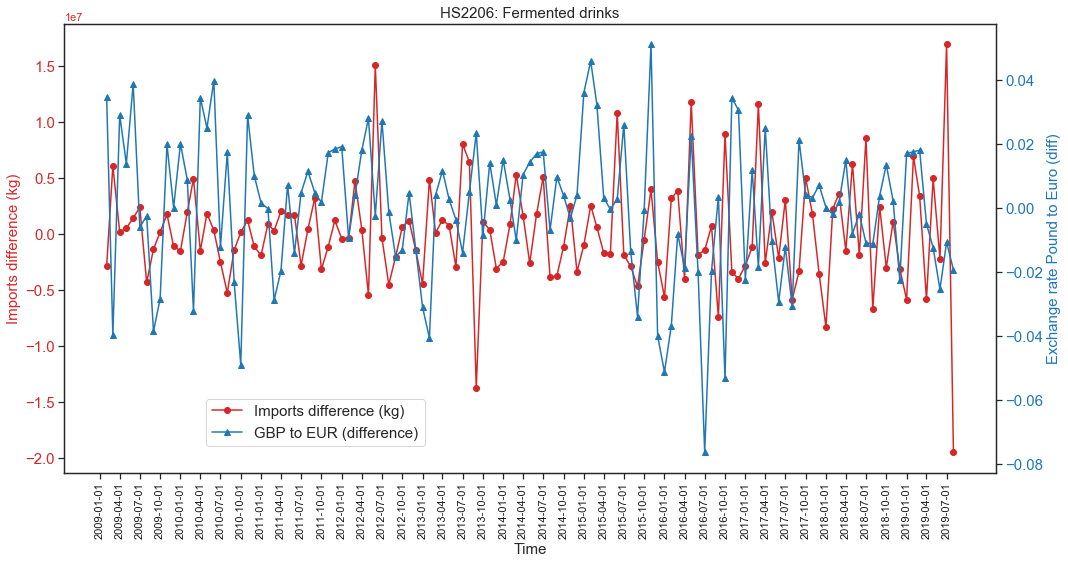

In [160]:
sns.set_style("ticks")
lag = 0

fig, ax1 = plt.subplots(figsize = (15,8))
color = 'tab:red'
ax1.set_xlabel('Time', fontsize = 15)
ax1.set_ylabel('Imports difference (kg)', color=color, fontsize = 15)
ax1.plot(data_2206['period'], data_2206['net_mass_kg_imp'].diff(), color = color, marker = 'o', ls = None)
ax1.tick_params(axis='y', labelcolor=color, labelsize = 15)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Exchange rate Pound to Euro (diff)', color=color, fontsize = 15) 
ax2.plot(data_2206['period'], data_2206['month_euro_gbp'].diff().shift(lag), color=color, marker = '^', ls = None)
ax2.tick_params(axis='y', labelcolor=color, labelsize = 15)
plt.xticks(ticks = data_2206.period[::3], rotation=90, fontsize = 15)
fig.tight_layout()  
ax1.tick_params(axis='x', which='major', labelcolor='k', rotation=90)
labels = ['Imports difference (kg)', 'GBP to EUR (difference)']
fig.legend(labels = labels, bbox_to_anchor=(0.4, 0.3), fontsize = 15)
plt.title('HS2206: Fermented drinks', fontsize = 15);
plt.tight_layout();
plt.savefig('ts_2206_cross_corr_nolag.jpeg', dpi=150)